# DecisionTreeClassifier
```
1. 有名的決策樹分類: ID3, C4.5, C5, CART, 官網沒有明說 sklearn應該是用CART, CART是使用Gini係數來決定屬性的重要性(sklear也讓你用entropy)
    1. 从根节点t=1开始，从所有可能候选S集合中搜索使不纯性降低最大的划分S，然后，使用划分S将节点1（t=1）划分成两个节点t=2和t=3； 
    2. 在t=2和t=3上分别重复划分搜索过程
    
2. 可用於2分法, 分多類也可以, 不適用於文章分類, 我個人認為可以用在客戶屬性分類上面, 只不過不是分群...
3. 參考資料: http://mropengate.blogspot.tw/2015/06/ai-ch13-2-decision-tree.html
            http://sjchen.im.nuu.edu.tw/MachineLearning/final/CLS_DT.pdf
            https://wizardforcel.gitbooks.io/dm-algo-top10/content/cart.html
```

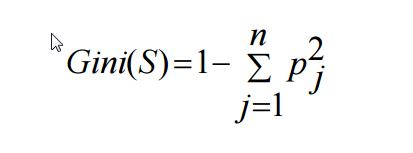

In [21]:
from IPython.display import Image
print('CART的Gini係數公式')
Image(filename='gini1.jpg')

In [8]:
"""
Gini_before <- 1- ( (9/14)^2 + (5/14)^2 )
print(Gini_before)    #ans = 0.4285714

Gini_weak <- 1- ( (6/8)^2 + (2/8)^2 )
Gini_strong <- 1- ( (3/6)^2 + (3/6)^2 )

Gini_after <- (8/14)*Gini_weak + (6/14)*Gini_strong
print(Gini_after)    #ans = 0.4285714

Gini_gain <- Gini_after - Gini_before
print(Gini_gain)    #ans = -0.03061224, 
#此例中分割完反而更差了
"""
from __future__ import division
giniBefore = 1 - ( (9/14)**2 + (5/14)**2 )
weak = 1 - ( (6/8)**2 + (2/8)**2 )
strong = 1 - ( (3/6)**2 + (3/6)**2 )
giniAfter = (8/14)*weak + (6/14)*strong
weak, strong, giniAfter - giniBefore

(0.375, 0.5, -0.030612244897959162)

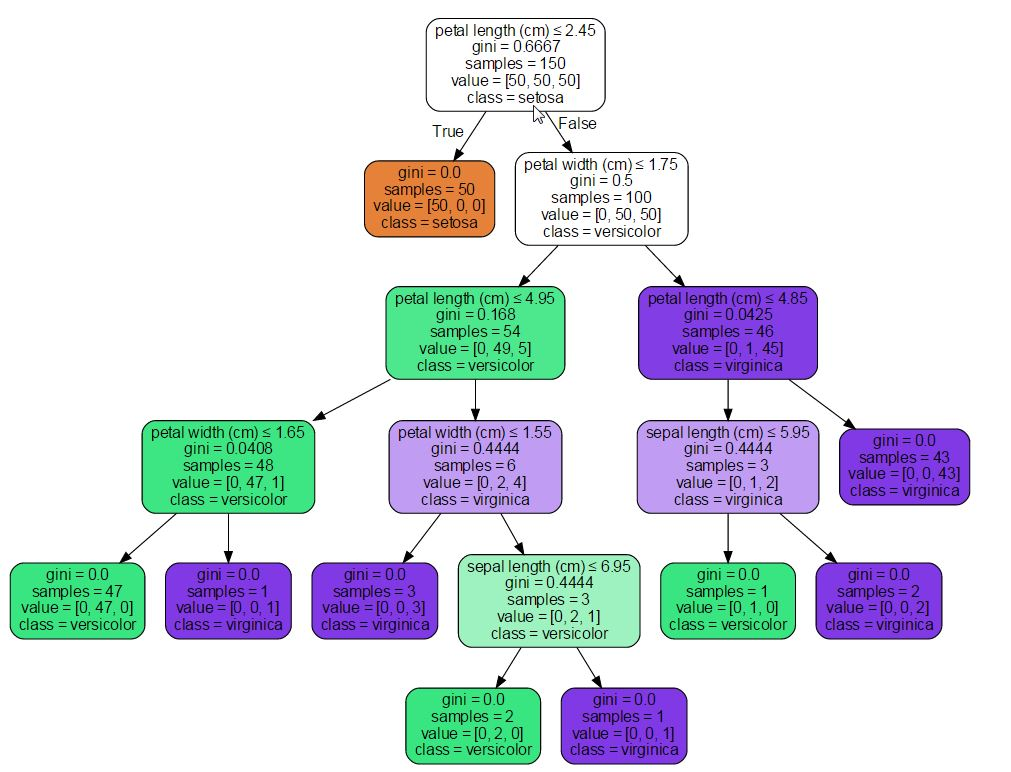

In [5]:
from IPython.display import Image
Image(filename='decision_tree.jpg')

In [3]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect('sklearnDs.sqlite') 

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [6]:
# 抓出頻果新聞資料
apple36Df, apple78Df = None, None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
    
    apple36Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160301_20160630_02
         order by batchno
    ''', sklearnConn)
apple36Df.head()

,forum,subject,term,keyword,content,pageurl
0,strange,農婦打噴嚏燒傷8頭驢 20萬飛了,山東 劉姓 農婦 打火機 編號 掛牌 噴嚏 倒楣 驢子 燒傷 人民幣 台幣 中國 齊魯 報導...,驢子 驢子 驢子 驢子 驢子 驢子 驢子 農婦 農婦 農婦 農婦 噴嚏 噴嚏 噴嚏 紋身 紋...,山東一名劉姓農婦，日前在用打火機替家中飼養的毛驢掛上編號掛牌時，忍不住打了個噴嚏，沒想到手一...,http://www.appledaily.com.tw/realtimenews/arti...
1,strange,最新款007座駕 日內瓦展前曝光,形象 英國 martin 旗下 十二 跑車 消息 國外 媒體 瑞士 時間 日內瓦 車展 推出...,車展 車展 新款 新款 優雅 優雅 力表 過動 渦輪引擎 曝光 曝光 渦輪 元則 端倪 ma...,形象與007專屬座駕密不可分的英國Aston Martin，旗下行之有年的DB9十二缸跑車，...,http://www.appledaily.com.tw/realtimenews/arti...
2,strange,上班族好無奈 最怕同事這些壞習慣,職場 同事 百款 上班族 星期 同事 時間 小時 小心 衛生習慣 公德心 習慣 同事 報導 ...,冰箱 冰箱 冰箱 同事 同事 同事 生氣 生氣 衛生習慣 百款 大吼大叫 易怒 公德心 公用...,職場同事百百款，身為一位上班族，一星期有5天必須跟同事見面，每天相處時間還得要8小時以上，如...,http://www.appledaily.com.tw/realtimenews/arti...
3,strange,【占卜】你為什麼想分手？,單身 相愛 分手 原因 家庭 壓力 第三者 金錢 工作 老師 數字 占卜 分手 原因 楊婷 ...,分手 分手 分手 分手 愛情 愛情 愛情 相愛 相愛 資料 資料 資料 資料 照片 照片 照...,你恢復單身了嗎？相愛容易相處難，會讓你想分手的原因是什麼呢？是家庭壓力、第三者、金錢還是工作...,http://www.appledaily.com.tw/realtimenews/arti...
4,strange,【旅途中】櫻花叢中的小精靈,櫻花 季節 發現 櫻花 雙活 眼睛 棲蘭 武陵農場 意外 漂亮 實在 可愛 小精靈 棲蘭 國...,棲蘭 棲蘭 櫻花 櫻花 櫻花 畫眉 畫眉 武陵農場 武陵農場 賞櫻 賞櫻 親子 親子 雙活 ...,春暖花開，又到了追櫻花的季節，有沒有發現粉嫩粉嫩的櫻花，幾雙活靈活現的的眼睛在盯著呢？愛玩姐...,http://www.appledaily.com.tw/realtimenews/arti...


In [7]:
# 用決策數來分類, 雖然慢, 但是數量大也不會跑到爆記憶體
# 分類結果比起svm來講, 稍微差了一點
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# limit = 1000
vec = TfidfVectorizer()
trainMx = vec.fit_transform(apple36Df.term)
clf = DecisionTreeClassifier()
clf.fit(trainMx, apple36Df.forum)
predicted = clf.predict(vec.transform(apple78Df.term))

In [10]:
print(metrics.classification_report(apple78Df.forum, predicted, target_names=clf.classes_))
pd.DataFrame(columns=clf.classes_, index=clf.classes_, data=metrics.confusion_matrix(apple78Df.forum, predicted))

               precision    recall  f1-score   support

           3c       0.91      0.73      0.81       734
       animal       0.73      0.46      0.56       673
entertainment       0.70      0.74      0.72      3082
      fashion       0.70      0.69      0.70       649
      finance       0.79      0.78      0.79      3201
        forum       0.61      0.57      0.59      1052
international       0.87      0.86      0.86      7579
         life       0.68      0.70      0.69      7029
        local       0.78      0.80      0.79      4971
     politics       0.66      0.61      0.64      2543
     property       0.98      0.89      0.93       551
       sports       0.91      0.84      0.88      3441
      strange       0.52      0.81      0.63      1120

  avg / total       0.77      0.76      0.76     36625



,3c,animal,entertainment,fashion,finance,forum,international,life,local,politics,property,sports,strange
3c,536,10,13,1,5,2,8,40,6,3,0,4,106
animal,5,308,100,3,2,1,22,51,35,2,0,1,143
entertainment,2,10,2273,94,66,26,74,283,99,42,0,48,65
fashion,0,2,114,449,28,2,7,32,1,3,0,6,5
finance,2,1,57,36,2505,31,180,243,33,86,5,10,12
forum,3,1,24,0,17,599,115,85,46,130,0,26,6
international,9,12,71,7,91,82,6492,236,131,74,0,73,301
life,16,23,341,32,313,83,223,4940,502,338,3,73,142
local,1,18,85,2,25,35,85,594,3976,104,0,18,28
politics,3,7,59,3,82,74,113,417,200,1560,3,15,7


Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.


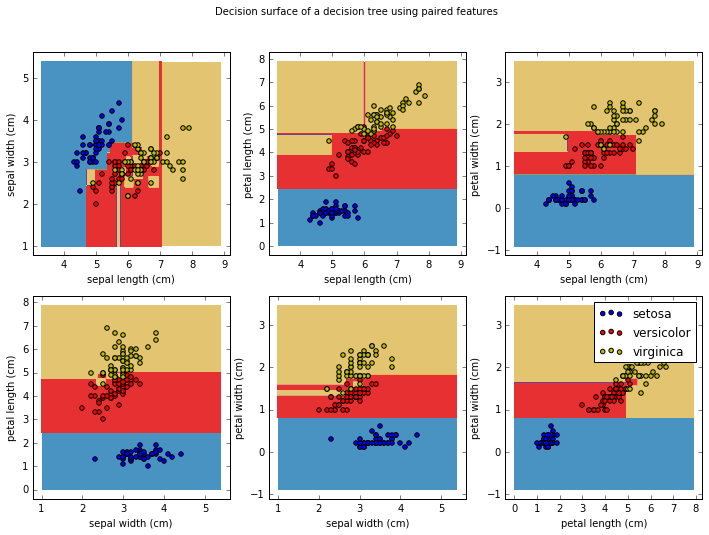

In [6]:
# 官網的範例

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Parameters
n_classes = 3
plot_colors = "bry"
plot_step = 0.02

# Load data
iris = load_iris()

plt.figure(figsize(12, 8))
for pairidx, pair in enumerate([[0, 1], [0, 2], [0, 3],
                                [1, 2], [1, 3], [2, 3]]):
    # We only take the two corresponding features
    X = iris.data[:, pair]
    y = iris.target

    # Train
    clf = DecisionTreeClassifier().fit(X, y)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.xlabel(iris.feature_names[pair[0]])
    plt.ylabel(iris.feature_names[pair[1]])
    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, label=iris.target_names[i],
                    cmap=plt.cm.Paired)

    plt.axis("tight")

plt.suptitle("Decision surface of a decision tree using paired features")
plt.legend()
plt.show()